c:\users\vik\appdata\local\programs\python\python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
c:\users\vik\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


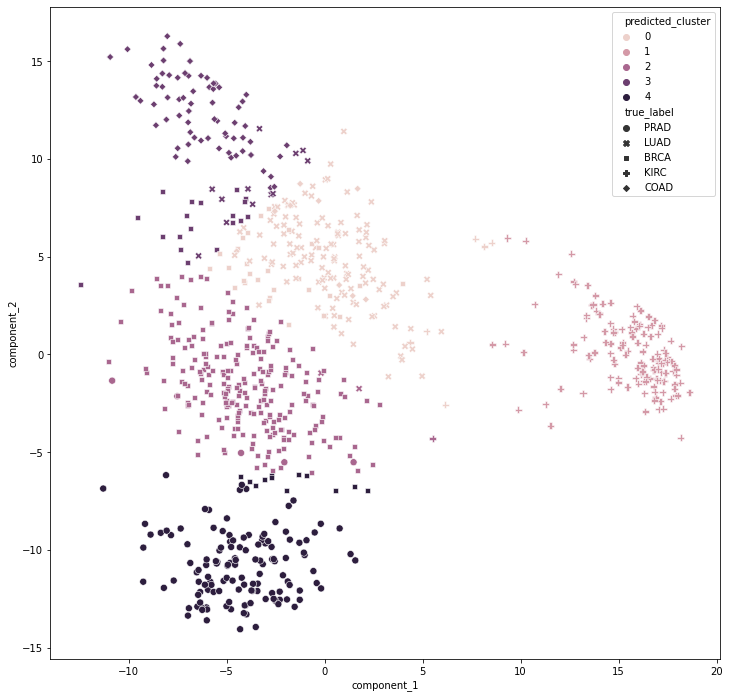

In [1]:
#A kmeans clustering pipeline to handle gene expression data from UC Irvine Machine Learning Lab

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

#Url for data: https://archive.ics.uci.edu/ml/machine-learning-databases/00401/TCGA-PANCAN-HiSeq-801x20531.tar.gz
#Download and extract

data_file="C:/pipeline_data/data.csv"
labels_file="C:/pipeline_data/labels.csv"

data_set=np.genfromtxt(data_file,delimiter=",",usecols=range(1,20532),skip_header=1)

label_names=np.genfromtxt(labels_file, delimiter=",",usecols=(1,),skip_header=1,dtype="str")

#Labels are cancer types, data_set shows gene expression values (more than 20,000) per sample
#Convert labels to integers so we can use:

label_encoder=LabelEncoder()
new_labels=label_encoder.fit_transform(label_names)

n_clusters=len(label_encoder.classes_) #store this value for later

# Now we use PCA for feature reduction, to reduce dimensions and lower the error

pre_processor=Pipeline([("scaler",MinMaxScaler()),("pca",PCA(n_components=2,random_state=42)),])
clusterer=Pipeline([("kmeans",KMeans(n_clusters=n_clusters,init="k-means++",n_init=50,max_iter=500,random_state=43,),),])

#Now combine to build a bigger pipeline:
pipe=Pipeline([("preprocessor",pre_processor),("clusterer",clusterer)])
pipe.fit(data_set)

#Now evaluate using silhouette coefficient:
preprocessed_data = pipe["preprocessor"].transform(data_set)
predicted_labels=pipe["clusterer"]["kmeans"].labels_
silhouette_score(preprocessed_data, predicted_labels)

#Silhouette score is 0.511, which is between 0 (clusters overlap), and 1 (clusters separated)

#Since only 2 principal components were selected, it is possible to plot:

pca_data=pd.DataFrame(pipe["preprocessor"].transform(data_set),columns=["component_1","component_2"])
pca_data["predicted_cluster"]=pipe["clusterer"]["kmeans"].labels_
pca_data["true_label"]=label_encoder.inverse_transform(new_labels) # re-convert integers back to original cancer string values

plt.figure(figsize=(12,12))
scat=sns.scatterplot("component_1","component_2",s=50,data=pca_data, hue="predicted_cluster", style="true_label")
plt.show()

#Note: by adjusting PCA components above, such as n_components=4, we get a lower silhouette score